# Modelisation

## Importation des modules et du dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler
import statsmodels.api as sm

data = pd.read_csv("dataset_cleaned.csv")

## Transformation des variables 

In [2]:
bmi_scale = [
    {"category": "Underweight", "range": [float("-inf"), 18.499]},
    {"category": "Healthy weight", "range": [18.5, 24.999]},
    {"category": "Overweight", "range": [25, 29.999]},
    {"category": "Obesity class I", "range": [30, 34.999]},
    {"category": "Obesity class II", "range": [35, 39.999]},
    {"category": "Obesity class III", "range": [40, float("inf")]},
]

bmi_count = []
for bmi in data["bmi"]:
    for group in bmi_scale:
        if bmi >= group["range"][0] and bmi <= group["range"][1]:
            bmi_count.append(group["category"])
            continue

data = data.drop("bmi", axis=1)
data["bmi"] = bmi_count

## Création des train set et test set

In [3]:
X = data.drop("charges", axis=1)
y = data.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

## Etapes de preprocessing 

### Fonction custom pour pipeline

In [116]:
# def bmi_categ(x):

#     df = pd.DataFrame(x)
    
#     bmi_count = []
#     for bmi in df["bmi"]:
#         for group in bmi_scale:
#             if bmi >= group["range"][0] and bmi <= group["range"][1]:
#                 bmi_count.append(group["category"])
#                 continue

#     df = df.drop("bmi", axis=1)
#     df["bmi"] = bmi_count
    
#     return df["bmi"]

### Preprocessing

In [22]:
num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

# num_col = ["age", "children"]
# cat_col = ["sex", "bmi", "smoker", "region"]

# num_pipe = make_pipeline(StandardScaler())

# custom_preprocessing = ColumnTransformer([
#     ("bmi_categ", FunctionTransformer(func=bmi_categ, validate=False), "bmi")
# ], remainder="passthrough")

# tenter avec feature engine -> pip install

preprocessing = ColumnTransformer([
    ("one_hot", OneHotEncoder(sparse_output=False), cat_col),
    ("scaling", StandardScaler(), num_col),
])

## Regression linéaire

In [5]:
linear_model = LinearRegression()

pipe_lr = make_pipeline(preprocessing, PolynomialFeatures(2), linear_model)
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test, y_test)

0.9174315504673247

## ElasticNet

In [8]:
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9)

pipe_en = make_pipeline(preprocessing, PolynomialFeatures(2), elastic_model)

pipe_en.fit(X_train, y_train)
pipe_en.score(X_test, y_test)

0.9174823660544655

### Recherche parametres avec grid search

In [7]:
params = {
    "elasticnet__alpha" : np.arange(0.4, 2, 0.2),
    "elasticnet__l1_ratio" : np.arange(0.4, 1, 0.2),
}

grid = GridSearchCV(pipe_en, param_grid=params, cv=5)

grid.fit(X_train, y_train)
display(grid.best_score_)
display(grid.score(X_test, y_test))
grid.best_params_

0.7991966248453848

0.8762770064721639

{'elasticnet__alpha': 0.4, 'elasticnet__l1_ratio': 0.8000000000000002}

## Ridge

In [9]:
ridge_model = Ridge(alpha=1.9)

pipe_r = make_pipeline(preprocessing, PolynomialFeatures(2), ridge_model)

cv_scores = cross_val_score(pipe_r, X, y, cv=5)
display(cv_scores)
display(cv_scores.mean())

pipe_r.fit(X_train, y_train)
pipe_r.score(X_test, y_test)

array([0.88546991, 0.78397845, 0.89000904, 0.84944601, 0.87109706])

0.8560000954008624

0.9210229258570933

### Recherches des parametres avec grid search

In [9]:
params = {
    "ridge__alpha" : np.arange(0.5, 2, 0.1)
}

grid = GridSearchCV(pipe_r, param_grid=params, cv=5)

grid.fit(X_train, y_train)
display(grid.best_score_)
display(grid.score(X_test, y_test))
grid.best_params_

0.8456389806068112

0.9203439595296002

{'ridge__alpha': 0.5}

## Lasso

In [23]:
lasso_model = Lasso(alpha=37.3)

pipe_l = make_pipeline(preprocessing, PolynomialFeatures(2), lasso_model)

pipe_l.fit(X_train, y_train)
print("Score du modèle sur le testing set : ", pipe_l.score(X_test, y_test))

Score du modèle sur le testing set :  0.922984950453674


### Coefficients des features du modele

In [29]:
feature_names = pipe_l[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe_l.named_steps["lasso"].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs["Absolute_values"] = coefs["Coefficients"].abs()

coefs = coefs.sort_values(by=["Absolute_values"], ascending=False)
coefs = coefs.drop("Absolute_values", axis=1)

coefs.to_csv("coef.csv")

display(coefs.head(11))

,Coefficients
one_hot__smoker_yes one_hot__bmi_Obesity class III,19336.583053
one_hot__smoker_yes one_hot__bmi_Obesity class II,18089.166678
one_hot__smoker_yes one_hot__bmi_Obesity class I,15851.297225
one_hot__smoker_no,-14230.714660
scaling__age,3475.600484
one_hot__smoker_yes one_hot__bmi_Healthy weight,-2093.970686
scaling__age^2,772.473113
one_hot__region_southwest,-658.039003
one_hot__region_northeast one_hot__bmi_Obesity class II,488.998561
one_hot__smoker_no one_hot__region_northeast,487.988456


### Prediction avec lasso

In [7]:
pred = {"age": 27,
        "sex": "male",
        "bmi": "Overweight",
        "children": 0,
        "smoker": "yes",
        "region": "northwest"
        }

prediction = pd.DataFrame(pred, index=[0])

pipe_l.predict(prediction)[0]

19189.998034741468

### Calcul des distance de Cook

In [44]:
X_train_poly = pipe_l.named_steps['polynomialfeatures'].transform(pipe_l.named_steps['columntransformer'].transform(X_train))

# Add a constant term to the design matrix
X_train_poly = sm.add_constant(X_train_poly)

# Fit an OLS (Ordinary Least Squares) model using statsmodels
ols_model = sm.OLS(y_train, X_train_poly).fit()

# Get the influence object
influence = ols_model.get_influence()

# Calculate Cook's distance
cook_distance = influence.cooks_distance

### Affichage des distances de cook

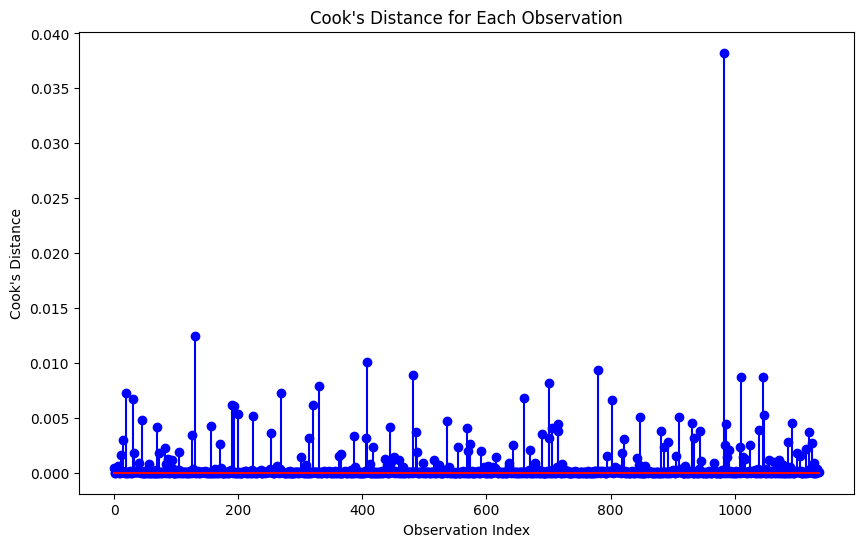

In [43]:
plt.figure(figsize=(10, 6))
plt.stem(cook_distance[0], linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

### Test de suppression des observations du train set ayant une distance de cook trop élevé

In [59]:
outliers = []

treshold = 4 / len(cook_distance[0])

for i in range(len(cook_distance[0])):
   if cook_distance[0][i] > 0.01:
      outliers.append(i)

display(len(outliers))

X_train_modified = X_train.drop(index=outliers, errors="ignore")
y_train_modified = y_train.drop(index=outliers, errors="ignore")

display(len(X_train_modified), len(y_train_modified))

pipe_l.fit(X_train_modified, y_train_modified)
display(pipe_l.score(X_test, y_test))

3

1133

1133

0.9228024016003843

### Graph de la régression linéaire

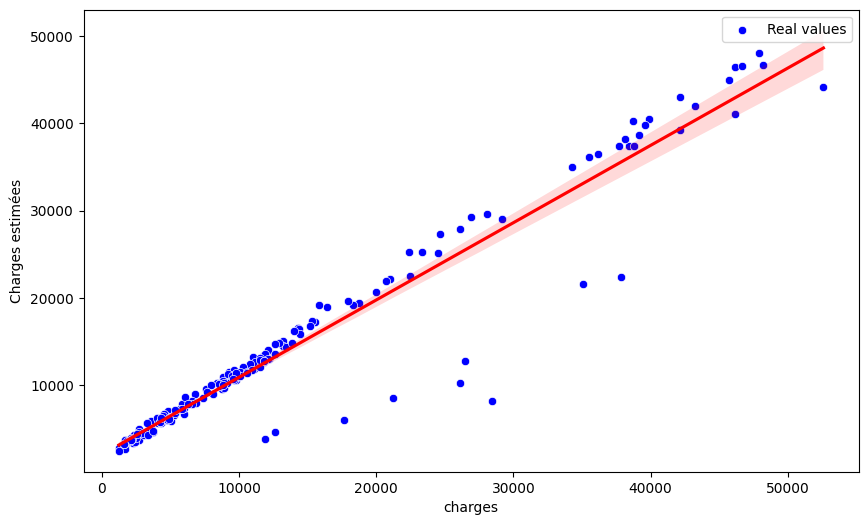

In [7]:
y_pred = pipe_l.predict(X_test)

x_color = 'blue'

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color=x_color, label='Real values')
plt.xlabel("Charges réelles")
plt.ylabel("Charges estimées")

sns.regplot(x=y_test, y=y_pred, scatter=False, color="red")
plt.show()

- Analyser les features les plus importantes avec une analyse des coefficients du model (.coef_), si le coeff est proche de 0 alors la feature a peu d'importance
- Analyser les observations qui ont une forte influence sur l'entrainement avec la distance de cook
- appliquer transformation dans le pipeline pour bmi avec tranform func -> Problème
- test sur les analyses bivariées (Correlation, Anova, Chi-2)